In [1]:
import os
import shutil
import random

# Define the paths for your dataset
dataset_path = '/kaggle/input/final-augmented-landmark/final_dataset_2'
train_path = '/kaggle/working/landmark_images/train'
test_path = '/kaggle/working/landmark_images/test'

# Create train and test directories if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Get the list of classes (folders) in your dataset
classes = os.listdir(dataset_path)

In [2]:
# Loop through each class folder
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    
    # Create train and test subdirectories for each class
    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_path, class_name), exist_ok=True)
    
    # Get the list of images in the class folder
    images = os.listdir(class_path)
    
    # Shuffle the images to randomize the split
    random.shuffle(images)
    
    # Calculate the split index based on an 80-20 ratio
    split_index = int(0.8 * len(images))
    
    # Move images to train and test folders based on the split index
    train_images = images[:split_index]
    test_images = images[split_index:]
    
    for image in train_images:
        src = os.path.join(class_path, image)
        dest = os.path.join(train_path, class_name, image)
        shutil.copy(src, dest)
    
    for image in test_images:
        src = os.path.join(class_path, image)
        dest = os.path.join(test_path, class_name, image)
        shutil.copy(src, dest)

print("Dataset split into train and test folders successfully.")

Dataset split into train and test folders successfully.


In [3]:
# Define the paths of the folders you want to delete
train_folder = '/kaggle/working/landmark_images/train/Oberoi Garden City'
test_folder = '/kaggle/working/landmark_images/test/Oberoi Garden City'

# Use shutil.rmtree() to delete the folders and their contents
try:
    shutil.rmtree(train_folder)
    print(f"Folder '{train_folder}' and its contents deleted successfully.")
except Exception as e:
    print(f"Error deleting folder '{train_folder}': {e}")

try:
    shutil.rmtree(test_folder)
    print(f"Folder '{test_folder}' and its contents deleted successfully.")
except Exception as e:
    print(f"Error deleting folder '{test_folder}': {e}")


Folder '/kaggle/working/landmark_images/train/Oberoi Garden City' and its contents deleted successfully.
Folder '/kaggle/working/landmark_images/test/Oberoi Garden City' and its contents deleted successfully.


In [4]:
!pip install livelossplot ipytest

In [5]:
# Import necessary libraries
import os
import urllib.request
from io import BytesIO
from zipfile import ZipFile
import multiprocessing
import concurrent.futures
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision import datasets, transforms
import torchvision.models as models
from tqdm import tqdm
from livelossplot import PlotLosses
from torch.optim.lr_scheduler import ReduceLROnPlateau
from livelossplot.outputs import MatplotlibPlot
import random
import math
import pytest
import tempfile

import ipytest
ipytest.autoconfig()

import warnings
# Ignore all warnings
warnings.simplefilter('ignore')

In [6]:
def get_data_location():
    """
    Determine the location of the dataset directory.

    Checks if the 'landmark_images' directory exists in the current working directory.
    If it does not exist, raises an IOError advising to download the dataset.

    Returns:
        data_folder (str): Path to the dataset directory.
    """
    if os.path.exists("/kaggle/working/landmark_images"):
        data_folder = "/kaggle/working/landmark_images"
    else:
        raise IOError("Dataset not found. Please download the dataset first.")

    return data_folder

In [7]:
try:
    data_path = get_data_location()
    print(f"Dataset path: {data_path}")
except IOError as e:
    print(e)

Dataset path: /kaggle/working/landmark_images


In [8]:
def compute_mean_and_std_concurrent():
    """
    Computes the per-channel mean and standard deviation of the dataset.
    Utilizes concurrent processing to speed up the calculation.
    Caches the results to disk to avoid recomputation.

    Returns:
        tuple: A tuple containing the mean and standard deviation tensors.
    """
    cache_file = '/kaggle/input/mean-and-std/mean_and_std (2).pt'

    # Check if cache exists to reuse computed mean and std
    if os.path.exists(cache_file):
        print('Reusing cached mean and std')
        data = torch.load(cache_file)
        return (data['mean'], data['std'])

    folder = get_data_location()  # Function to get dataset location
    ds = datasets.ImageFolder(folder, transform=transforms.Compose([transforms.ToTensor()]))
    dl = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=0)

    def compute_mean(images):
        """Compute mean across all images in a batch."""
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        return images.mean(2).sum(0)

    mean = 0.0
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        # Compute mean for each batch and accumulate
        futures = [executor.submit(compute_mean, images) for images, _ in dl]
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(ds), desc='Computing mean', ncols=80):
            mean += future.result()
    mean /= len(dl.dataset)

    def compute_var_and_npix(images):
        """Compute variance and number of pixels across all images in a batch."""
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        var = ((images - mean.unsqueeze(1)) ** 2).sum([0, 2])
        npix = images.nelement()
        return var, npix

    var = 0.0
    npix = 0
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        # Compute variance and pixel count for each batch and accumulate
        futures = [executor.submit(compute_var_and_npix, images) for images, _ in dl]
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(ds), desc='Computing std', ncols=80):
            var_value, npix_value = future.result()
            var += var_value
            npix += npix_value
    std = torch.sqrt(var / (npix / 3))

    # Cache the computed mean and std to disk
    torch.save({'mean': mean, 'std': std}, cache_file)

    return mean, std

In [9]:
# Check if a GPU is available and set the device accordingly
use_cuda = torch.cuda.is_available()

if use_cuda:
    print("GPU available. Execution mode: GPU (Fast)")
else:
    print("GPU not available. Execution mode: CPU (Slower)")

GPU available. Execution mode: GPU (Fast)


In [10]:
# Seed the random number generators to ensure reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Calculate the mean and standard deviation of the dataset for normalization
compute_mean_and_std_concurrent()

# Create a 'checkpoints' directory for saving model checkpoints during training, if it doesn't already exist
os.makedirs("checkpoints", exist_ok=True)

Reusing cached mean and std


In [11]:
def get_data_loaders(batch_size: int = 32, valid_size: float = 0.2, num_workers: int = -1, limit: int = -1):
    """
    Create and returns the train, validation, and test data loaders.

    Parameters:
        batch_size (int): Size of the mini-batches.
        valid_size (float): Fraction of the dataset to use for validation. For example, 0.2 means that 20% of the dataset will be used for validation.
        num_workers (int): Number of workers to use in the data loaders. Use num_workers=1 for simplicity.
        limit (int): Maximum number of data points to consider. A negative value indicates no limit.

    Returns:
        dict: A dictionary with keys 'train', 'valid', and 'test' containing the respective data loaders.
    """
    
    if num_workers == -1:
        # Use all cores
        num_workers = multiprocessing.cpu_count()

    # Initialize the data loaders dictionary
    data_loaders = {"train": None, "valid": None, "test": None}

    # Path to dataset
    base_path = Path(get_data_location())

    # Compute mean and std of the dataset
    mean, std = compute_mean_and_std_concurrent()
    print(f"Dataset mean: {mean}, std: {std}")

    # Data transformations
    data_transforms = {
        "train": transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ]),
        "valid": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ]),
        "test": transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ]),
    }

    # Creating datasets with the appropriate transforms
    train_data = datasets.ImageFolder(base_path / "train", transform=data_transforms["train"])
    valid_data = datasets.ImageFolder(base_path / "train", transform=data_transforms["valid"])

    # Splitting the dataset into train and validation sets
    n_tot = len(train_data)
    indices = torch.randperm(n_tot).tolist()

    # Limit the dataset if requested
    if limit > 0:
        indices = indices[:limit]
        n_tot = limit

    split = int(math.ceil(valid_size * n_tot))
    train_idx, valid_idx = indices[split:], indices[:split]

    # Samplers for obtaining training and validation batches
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

    # Data loaders for training and validation datasets
    data_loaders["train"] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
    data_loaders["valid"] = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

    # Creating the test dataset and dataloader
    test_data = datasets.ImageFolder(base_path / "test", transform=data_transforms["test"])
    test_sampler = None if limit <= 0 else torch.utils.data.SubsetRandomSampler(torch.arange(limit))

    data_loaders["test"] = torch.utils.data.DataLoader(test_data, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers, shuffle=False if limit > 0 else True)

    return data_loaders

In [12]:
def visualize_one_batch(data_loaders, max_n: int = 5):
    """
    Visualize one batch of data from the training dataset.

    Parameters:
    - data_loaders (dict): Dictionary containing data loaders for 'train', 'valid', and 'test'.
    - max_n (int): Maximum number of images to display in one row.

    Returns:
    - None: Displays a batch of images with labels.
    """

    # Obtain one batch of training images from the train data loader
    dataiter = iter(data_loaders['train'])
    images, labels = next(dataiter)

    # Undo the normalization for visualization
    # Note: This assumes the mean and std used for normalization are available
    mean, std = compute_mean_and_std_concurrent()  # Assuming this function returns the global mean and std used for normalization
    invTrans = transforms.Compose([
        transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1 / s for s in std]),
        transforms.Normalize(mean=[-m for m in mean], std=[1.0, 1.0, 1.0])
    ])

    # Apply the inverse transformations to the images
    images_inv = invTrans(images)

    # Get class names from the dataset
    class_names = data_loaders['train'].dataset.classes

    # Convert images to numpy for visualization
    images_np = images_inv.numpy()

    # Convert from PyTorch's channel-first format (C, H, W) to channel-last format (H, W, C) for matplotlib
    images_np = np.transpose(images_np, (0, 2, 3, 1))

    # Ensure image pixel values are within the [0, 1] range
    images_np = np.clip(images_np, 0, 1)

    # Plot the images with labels
    fig = plt.figure(figsize=(25, 4))
    for idx in range(min(max_n, images_np.shape[0])):
        ax = fig.add_subplot(1, max_n, idx + 1, xticks=[], yticks=[])
        ax.imshow(images_np[idx])
        # Set the title of each subplot to the corresponding image label
        ax.set_title(class_names[labels[idx].item()])

In [13]:
######################################################################################
#                                     TESTS
######################################################################################


@pytest.fixture(scope="session")
def data_loaders():
    return get_data_loaders(batch_size=2, num_workers=0)


def test_data_loaders_keys(data_loaders):

    assert set(data_loaders.keys()) == {"train", "valid", "test"}, "The keys of the data_loaders dictionary should be train, valid and test"


def test_data_loaders_output_type(data_loaders):
    # Test the data loaders
    dataiter = iter(data_loaders["train"])
    images, labels = next(dataiter)

    assert isinstance(images, torch.Tensor), "images should be a Tensor"
    assert isinstance(labels, torch.Tensor), "labels should be a Tensor"
    assert images[0].shape[-1] == 224, "The tensors returned by your dataloaders should be 224x224. Did you " \
                                       "forget to resize and/or crop?"


def test_data_loaders_output_shape(data_loaders):
    dataiter = iter(data_loaders["train"])
    images, labels = next(dataiter)

    assert len(images) == 2, f"Expected a batch of size 2, got size {len(images)}"
    assert (
        len(labels) == 2
    ), f"Expected a labels tensor of size 2, got size {len(labels)}"


def test_visualize_one_batch(data_loaders):

    visualize_one_batch(data_loaders, max_n=2)


In [14]:
ipytest.run('-vv', '-k', 'data_loaders')

======================================= test session starts ========================================
platform linux -- Python 3.10.13, pytest-8.1.1, pluggy-1.4.0 -- /opt/conda/bin/python3.10
cachedir: .pytest_cache
rootdir: /kaggle/working
plugins: anyio-4.2.0, typeguard-4.1.5
collecting ... collected 4 items / 1 deselected / 3 selected

t_44c27bcfadd04b47a0a0f4ee554dd3d3.py::test_data_loaders_keys PASSED                         [ 33%]
t_44c27bcfadd04b47a0a0f4ee554dd3d3.py::test_data_loaders_output_type PASSED                  [ 66%]
t_44c27bcfadd04b47a0a0f4ee554dd3d3.py::test_data_loaders_output_shape PASSED                 [100%]

================================= 3 passed, 1 deselected in 0.64s ==================================


<ExitCode.OK: 0>

======================================= test session starts ========================================
platform linux -- Python 3.10.13, pytest-8.1.1, pluggy-1.4.0 -- /opt/conda/bin/python3.10
cachedir: .pytest_cache
rootdir: /kaggle/working
plugins: anyio-4.2.0, typeguard-4.1.5
collecting ... collected 4 items / 3 deselected / 1 selected

t_44c27bcfadd04b47a0a0f4ee554dd3d3.py::test_visualize_one_batch PASSED                       [100%]

================================= 1 passed, 3 deselected in 0.37s ==================================


<ExitCode.OK: 0>

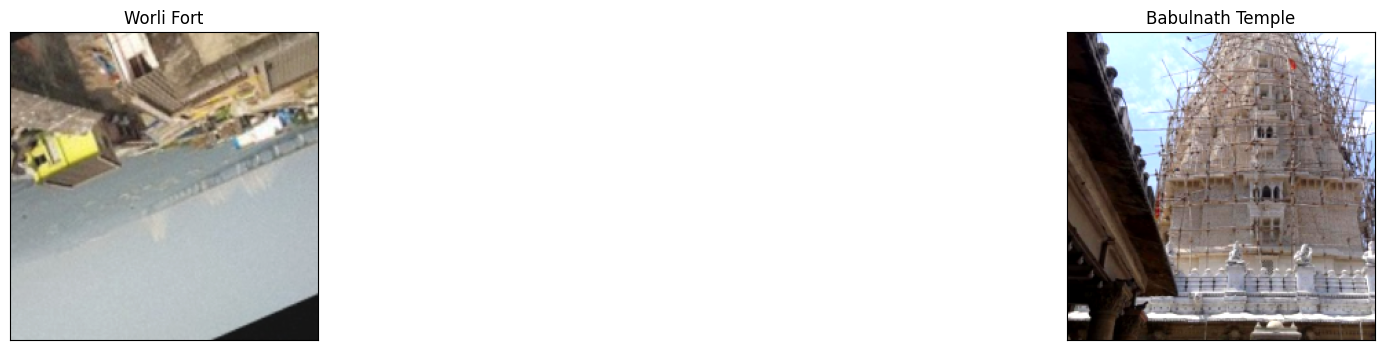

In [15]:
ipytest.run('-vv', '-k', 'visualize_one_batch')

Reusing cached mean and std
Dataset mean: tensor([0.4033, 0.4029, 0.3889]), std: tensor([0.3028, 0.3074, 0.3257])
Reusing cached mean and std


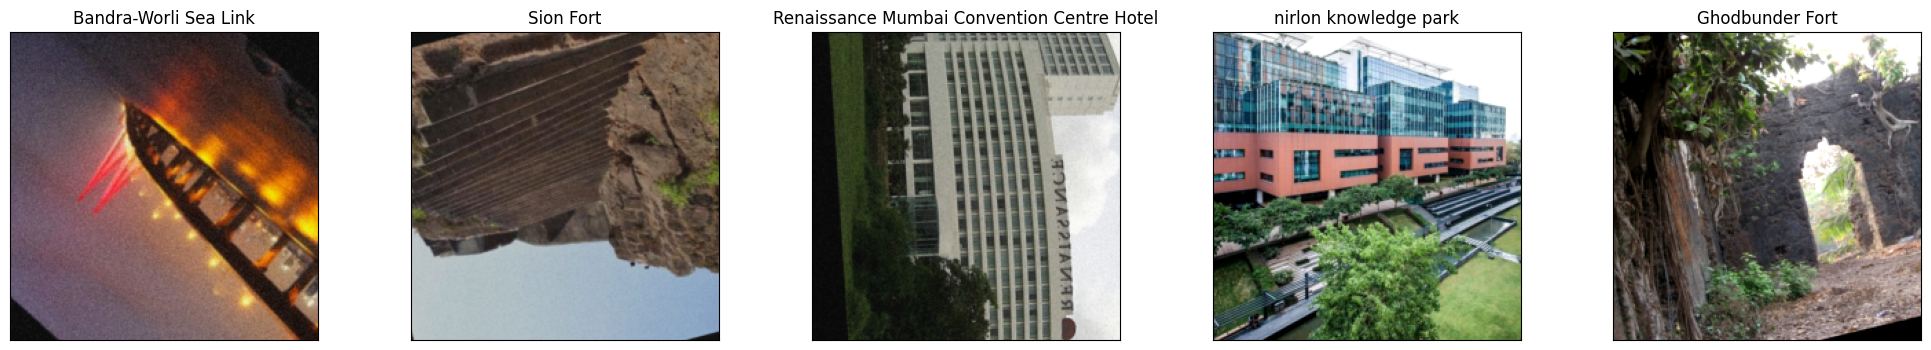

In [16]:
%matplotlib inline

# Instantiating the data_loaders with specified parameters
data_loaders = get_data_loaders(batch_size=5, valid_size=0.01, num_workers=-1)

# Visualizing one batch from the data loaders
visualize_one_batch(data_loaders)

In [17]:
def get_loss(use_cuda=False):
    """
    Get an instance of the CrossEntropyLoss.
    If use_cuda is True and a GPU is available, the loss will be moved to the GPU.
    """
    loss = nn.CrossEntropyLoss()
    if use_cuda and torch.cuda.is_available():
        loss = loss.cuda()
    return loss

def get_optimizer(model: nn.Module, optimizer: str = "SGD", learning_rate: float = 0.01, momentum: float = 0.5, weight_decay: float = 0):
    """
    Returns an optimizer instance based on the specified optimizer type and parameters.
    """
    if optimizer.lower() == "sgd":
        opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    elif optimizer.lower() == "adam":
        opt = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        raise ValueError(f"Optimizer {optimizer} not supported")
    return opt


In [18]:
######################################################################################
#                                     TESTS
######################################################################################

@pytest.fixture(scope="session")
def fake_model():
    return nn.Linear(16, 256)


def test_get_loss():

    loss = get_loss()

    assert isinstance(
        loss, nn.CrossEntropyLoss
    ), f"Expected cross entropy loss, found {type(loss)}"


def test_get_optimizer_type(fake_model):

    opt = get_optimizer(fake_model)

    assert isinstance(opt, torch.optim.SGD), f"Expected SGD optimizer, got {type(opt)}"


def test_get_optimizer_is_linked_with_model(fake_model):

    opt = get_optimizer(fake_model)

    assert opt.param_groups[0]["params"][0].shape == torch.Size([256, 16])


def test_get_optimizer_returns_adam(fake_model):

    opt = get_optimizer(fake_model, optimizer="adam")

    assert opt.param_groups[0]["params"][0].shape == torch.Size([256, 16])
    assert isinstance(opt, torch.optim.Adam), f"Expected SGD optimizer, got {type(opt)}"


def test_get_optimizer_sets_learning_rate(fake_model):

    opt = get_optimizer(fake_model, optimizer="adam", learning_rate=0.123)

    assert (
        opt.param_groups[0]["lr"] == 0.123
    ), "get_optimizer is not setting the learning rate appropriately. Check your code."


def test_get_optimizer_sets_momentum(fake_model):

    opt = get_optimizer(fake_model, optimizer="SGD", momentum=0.123)

    assert (
        opt.param_groups[0]["momentum"] == 0.123
    ), "get_optimizer is not setting the momentum appropriately. Check your code."


def test_get_optimizer_sets_weight_decat(fake_model):

    opt = get_optimizer(fake_model, optimizer="SGD", weight_decay=0.123)

    assert (
        opt.param_groups[0]["weight_decay"] == 0.123
    ), "get_optimizer is not setting the weight_decay appropriately. Check your code."


In [19]:
# Run tests that specifically test the model construction
ipytest.run('-vv', '-k', 'get_loss')

======================================= test session starts ========================================
platform linux -- Python 3.10.13, pytest-8.1.1, pluggy-1.4.0 -- /opt/conda/bin/python3.10
cachedir: .pytest_cache
rootdir: /kaggle/working
plugins: anyio-4.2.0, typeguard-4.1.5
collecting ... collected 11 items / 10 deselected / 1 selected

t_44c27bcfadd04b47a0a0f4ee554dd3d3.py::test_get_loss PASSED                                  [100%]

================================= 1 passed, 10 deselected in 0.02s =================================


<ExitCode.OK: 0>

In [20]:
# Run tests that specifically test the model construction
ipytest.run('-vv', '-k', 'get_optimizer')

======================================= test session starts ========================================
platform linux -- Python 3.10.13, pytest-8.1.1, pluggy-1.4.0 -- /opt/conda/bin/python3.10
cachedir: .pytest_cache
rootdir: /kaggle/working
plugins: anyio-4.2.0, typeguard-4.1.5
collecting ... collected 11 items / 5 deselected / 6 selected

t_44c27bcfadd04b47a0a0f4ee554dd3d3.py::test_get_optimizer_type PASSED                        [ 16%]
t_44c27bcfadd04b47a0a0f4ee554dd3d3.py::test_get_optimizer_is_linked_with_model PASSED        [ 33%]
t_44c27bcfadd04b47a0a0f4ee554dd3d3.py::test_get_optimizer_returns_adam PASSED                [ 50%]
t_44c27bcfadd04b47a0a0f4ee554dd3d3.py::test_get_optimizer_sets_learning_rate PASSED          [ 66%]
t_44c27bcfadd04b47a0a0f4ee554dd3d3.py::test_get_optimizer_sets_momentum PASSED               [ 83%]
t_44c27bcfadd04b47a0a0f4ee554dd3d3.py::test_get_optimizer_sets_weight_decat PASSED           [100%]

================================= 6 passed, 5 deselected i

<ExitCode.OK: 0>

In [21]:
def train_one_epoch(train_dataloader, model, optimizer, loss_fn, epoch=0):
    """
    Performs one training epoch

    Parameters:
    - train_dataloader: DataLoader for the training data
    - model: The neural network model to train
    - optimizer: Optimizer used to update model parameters
    - loss_fn: Loss function to calculate the loss

    Returns:
    - train_loss: Average loss for this training epoch
    """

    # Transfer the model to GPU if available
    if torch.cuda.is_available():
        model.cuda()

    # Set the model to training mode
    model.train()

    train_loss = 0.0

    for batch_idx, (data, target) in tqdm(enumerate(train_dataloader), desc=f"Epoch {epoch} Training", total=len(train_dataloader), leave=True, ncols=80):
        # Move data to GPU if available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # Calculate the loss
        loss_value = loss_fn(output, target)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss_value.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Update running training loss
        train_loss += (1 / (batch_idx + 1)) * (loss_value.data.item() - train_loss)

    return train_loss

In [22]:
def valid_one_epoch(valid_dataloader, model, loss_fn, epoch=0):
    """
    Validate the model at the end of one epoch

    Parameters:
    - valid_dataloader: DataLoader for the validation data
    - model: The neural network model to validate
    - loss_fn: Loss function to calculate the loss

    Returns:
    - valid_loss: Average loss for this validation phase
    """

    # No gradient calculation is needed
    with torch.no_grad():

        # Set the model to evaluation mode
        model.eval()

        # Transfer the model to GPU if available
        if torch.cuda.is_available():
            model.cuda()

        valid_loss = 0.0

        for batch_idx, (data, target) in tqdm(enumerate(valid_dataloader), desc=f"Epoch {epoch} Validating", total=len(valid_dataloader), leave=True, ncols=80):
            # Move data to GPU if available
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # Calculate the loss
            loss_value = loss_fn(output, target)

            # Update running validation loss
            valid_loss += (1 / (batch_idx + 1)) * (loss_value.data.item() - valid_loss)

    return valid_loss

In [23]:
def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
    """Add title xlabel and legend to single chart"""
    ax.set_title(group_name)
    ax.set_xlabel(x_label)
    ax.legend(loc="center right")

    if group_name.lower() == "loss":
        ax.set_ylim([None, 4.5])

In [24]:
def optimize(data_loaders, model, optimizer, loss_fn, n_epochs, save_path, interactive_tracking=False, early_stopping_patience=5):
    """
    Function to perform the training and validation loop, including interactive tracking and saving the best model.
    """
    if interactive_tracking:
        liveloss = PlotLosses(outputs=[MatplotlibPlot(after_subplot=after_subplot)])
    else:
        liveloss = None

    valid_loss_min = float('inf')  # Initialize the minimum validation loss
    epochs_without_improvement = 0
    logs = {}

    # Setup the learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    for epoch in range(1, n_epochs + 1):
        train_loss = train_one_epoch(data_loaders["train"], model, optimizer, loss_fn, epoch)
        valid_loss = valid_one_epoch(data_loaders["valid"], model, loss_fn, epoch)

        # Print training/validation statistics
        print(f"Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}")

        # Save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...")
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping after {epoch} epochs without improvement.")
            break

        # Update the learning rate
        scheduler.step(valid_loss)

        # Interactive tracking
        if interactive_tracking:
            logs["loss"] = train_loss
            logs["val_loss"] = valid_loss
            logs["lr"] = optimizer.param_groups[0]["lr"]
            liveloss.update(logs)
            liveloss.send()

In [25]:
def one_epoch_test(test_dataloader, model, loss_fn):
    """
    Test the model performance on the test set.
    """
    test_loss = 0.
    correct = 0.
    total = 0.

    # Set the model to evaluation mode
    model.eval()

    if torch.cuda.is_available():
        model.cuda()

    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_dataloader), desc='Testing', total=len(test_dataloader), leave=True, ncols=80):
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # Forward pass
            logits = model(data)
            loss_value = loss_fn(logits, target)

            # Update test loss
            test_loss += (1 / (batch_idx + 1)) * (loss_value.item() - test_loss)

            # Convert logits to predicted class
            _, pred = torch.max(logits, 1)

            # Compare predictions to true label
            correct += pred.eq(target.data.view_as(pred)).sum().item()
            total += data.size(0)

    print(f'Test Loss: {test_loss:.6f}\n')
    print(f'Test Accuracy: {100. * correct / total:.2f}% ({correct}/{total})')

    return test_loss

In [26]:
class Predictor(nn.Module):

    def __init__(self, model, class_names, mean, std):
        super().__init__()

        self.model = model.eval()
        self.class_names = class_names

        # We use nn.Sequential and not nn.Compose because the former
        # is compatible with torch.script, while the latter isn't
        self.transforms = nn.Sequential(
            T.Resize([256, ]),  # We use single int value inside a list due to torchscript type restrictions
            T.CenterCrop(224),
            T.ConvertImageDtype(torch.float),
            T.Normalize(mean.tolist(), std.tolist())
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            # 1. apply transforms
            x  = self.transforms(x)
            # 2. get the logits
            x  = self.model(x)# YOUR CODE HERE
            # 3. apply softmax
            #    HINT: remmeber to apply softmax across dim=1
            x  = F.softmax(x, dim=1)# YOUR CODE HERE

            return x

In [27]:
def predictor_test(test_dataloader, model_reloaded):
    """
    Test the predictor. Since the predictor does not operate on the same tensors
    as the non-wrapped model, we need a specific test function (can't use one_epoch_test)
    """

    folder = get_data_location()
    test_data = datasets.ImageFolder(os.path.join(folder, "test"), transform=T.ToTensor())

    pred = []
    truth = []
    for x in tqdm(test_data, total=len(test_dataloader.dataset), leave=True, ncols=80):
        softmax = model_reloaded(x[0].unsqueeze(dim=0))

        idx = softmax.squeeze().argmax()

        pred.append(int(x[1]))
        truth.append(int(idx))

    pred = np.array(pred)
    truth = np.array(truth)

    print(f"Accuracy: {(pred==truth).sum() / pred.shape[0]}")

    return truth, pred

## Transfer Learning

In [28]:
train_directory = os.path.join(get_data_location(), 'train')
num_classes = len(os.listdir(train_directory))
print('Number of classes:', num_classes)

Number of classes: 87


In [29]:
def get_model_transfer_learning(model_name="resnet50", n_classes=num_classes):
    """
    Initializes a pretrained model for transfer learning tailored to a specific number of classes.

    Parameters:
    - model_name (str): Name of the model architecture to use. Default is ResNet-50.
    - n_classes (int): Number of classes for the final output layer.

    Returns:
    - model_transfer (torch.nn.Module): Pretrained model adapted for the specified number of classes.
    """
    
    # Check if the requested model architecture is available in torchvision
    if hasattr(models, model_name):
        # Initialize the model with pretrained weights
        model_transfer = getattr(models, model_name)(pretrained=True)
    else:
        # Provide guidance if the model name is incorrect or not available
        torchvision_major_minor = ".".join(torchvision.__version__.split(".")[:2])
        raise ValueError(f"Model {model_name} is not known. Please refer to the list of available models: "
                         f"https://pytorch.org/vision/{torchvision_major_minor}/models.html")

    # Freeze all the model parameters to prevent them from being updated during training
    for param in model_transfer.parameters():
        param.requires_grad = False

    # Replace the model's final layer (fully connected layer) to match the number of classes
    # Note: The attribute for the final layer might differ based on the model architecture.
    # For ResNet, it's 'fc'. For other models like VGG or AlexNet, it might be 'classifier[6]'.
    num_ftrs = model_transfer.fc.in_features  # Get the input feature size of the existing layer
    model_transfer.fc = nn.Linear(num_ftrs, n_classes)  # Replace it with a new linear layer

    return model_transfer

In [30]:
######################################################################################
#                                     TESTS
######################################################################################

@pytest.fixture(scope="session")
def data_loaders():

    return get_data_loaders(batch_size=2)


def test_get_model_transfer_learning(data_loaders):

    model = get_model_transfer_learning(n_classes=23)

    dataiter = iter(data_loaders["train"])
    images, labels = next(dataiter)

    out = model(images)

    assert isinstance(
        out, torch.Tensor
    ), "The output of the .forward method should be a Tensor of size ([batch_size], [n_classes])"

    assert out.shape == torch.Size(
        [2, 23]
    ), f"Expected an output tensor of size (2, 23), got {out.shape}"

In [31]:
ipytest.run('-vv', '-k', 'test_get_model_transfer_learning')

======================================= test session starts ========================================
platform linux -- Python 3.10.13, pytest-8.1.1, pluggy-1.4.0 -- /opt/conda/bin/python3.10
cachedir: .pytest_cache
rootdir: /kaggle/working
plugins: anyio-4.2.0, typeguard-4.1.5
collecting ... collected 12 items / 11 deselected / 1 selected

t_44c27bcfadd04b47a0a0f4ee554dd3d3.py::test_get_model_transfer_learning PASSED               [100%]

================================= 1 passed, 11 deselected in 2.41s =================================


<ExitCode.OK: 0>

In [32]:
batch_size = 64  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 50 # number of epochs for training
num_classes = num_classes # number of classes. Do not change this
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0 # regularization. Increase this to combat overfitting

In [33]:
model_transfer = get_model_transfer_learning("resnet50", n_classes=num_classes)

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)

optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

Reusing cached mean and std
Dataset mean: tensor([0.4033, 0.4029, 0.3889]), std: tensor([0.3028, 0.3074, 0.3257])


In [34]:
# Assuming model_transfer is your ResNet model with pretrained weights and fc layer modified for your task
# Unfreeze the last few layers (layer3 and layer4) for training
unfreeze_layers = ['layer4']

for name, child in model_transfer.named_children():
    if name in unfreeze_layers:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

# Verify which layers are trainable now
for name, param in model_transfer.named_parameters():
    if param.requires_grad:
        print(name)

layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.conv3.weight
layer4.0.bn3.weight
layer4.0.bn3.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
layer4.1.conv3.weight
layer4.1.bn3.weight
layer4.1.bn3.bias
layer4.2.conv1.weight
layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
layer4.2.conv3.weight
layer4.2.bn3.weight
layer4.2.bn3.bias


In [35]:
def print_model_summary(model):
    print(model)
    print("Model Summary:")
    print("=" * 70)
    print("{:<20} {:<25} {:<15}".format("Layer Name", "Output Shape", "Param #"))
    print("=" * 70)
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            total_params += param.numel()
            print("{:<20} {:<25} {:<15}".format(name, str(list(param.shape)), param.numel()))
    print("=" * 70)
    print(f"Total Trainable Parameters: {total_params}")

# Usage
# model = MyModel(num_classes=num_classes, dropout=dropout)
print_model_summary(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

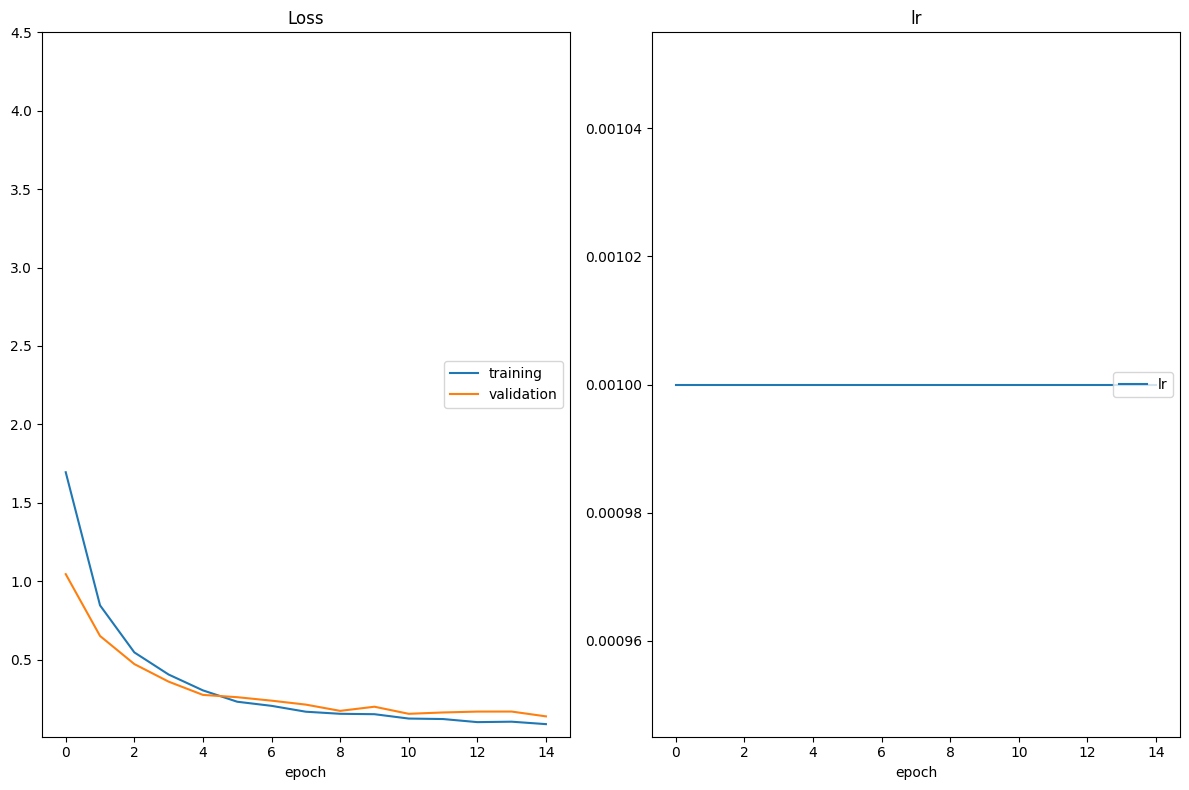

Epoch 16 Validating: 100%|██████████████████████| 75/75 [00:37<00:00,  2.00it/s]

Epoch: 16 	Training Loss: 0.095678 	Validation Loss: 0.182564
Early stopping after 16 epochs without improvement.


In [36]:
optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="landmark_classifier.pt",
    interactive _tracking=True
)

In [38]:
# Load saved weights
model_transfer.load_state_dict(torch.load('landmark_classifier.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 95/95 [00:45<00:00,  2.09it/s]

Test Loss: 0.132659

Test Accuracy: 96.39% (5819.0/6037.0)


0.1326588729494497

In [39]:
import shutil

source_path = '/kaggle/working/checkpoints/model_transfer.pt'
destination_path = '/kaggle/working/model_transfer.pt'

shutil.copyfile(source_path, destination_path)

'/kaggle/working/model_transfer.pt'

In [41]:
# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load("/kaggle/working/checkpoints/model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std_concurrent()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


In [ ]:
# Load the model's state dictionary using torch.load
model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

# Perform testing using the loaded model
pred, truth = predictor_test(data_loaders['test'], model_transfer)

In [ ]:
import pandas as pd
import seaborn as sns

# Plot confusion matrix
gt = pd.Series(truth, name='Ground Truth')
predicted = pd.Series(pred, name='Predicted')
confusion_matrix = pd.crosstab(gt, predicted)

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt='d', ax=ax, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Upload image and test your model

In [44]:
from ipywidgets import VBox, FileUpload, Button, Label, Output, HTML
from PIL import Image
from IPython.display import display
import io
import numpy as np
import torchvision
import torchvision.transforms as T
import torch

In [45]:
# Decide which model you want to use among the ones exported
# Assume learn_inf is your TorchScript JIT model loaded from "checkpoints/transfer_exported.pt"
learn_inf = torch.jit.load("/kaggle/working/checkpoints/transfer_exported.pt")

In [46]:
def update_label_style(label, landmark_name, confidence):
    """
    Update the style of the label based on the confidence level of the prediction.

    Parameters:
    - label: The Label widget to update.
    - landmark_name: The predicted landmark name.
    - confidence: The confidence level (probability) of the prediction.
    """
    if confidence >= 0.6:
        label.value = f'<span style="font-weight:bold; font-size:large;">{landmark_name} (prob: {confidence:.2f})</span>'
    else:
        label.value = f'<span style="font-size:small;">{landmark_name} (prob: {confidence:.2f})</span>'

In [47]:
def on_click_classify(change):
    # Load image that has been uploaded
    fn = io.BytesIO(btn_upload.data[-1])
    img = Image.open(fn)
    img.load()

    # Clear the previous output
    out_pl.clear_output()

    # Display the image
    with out_pl:
        ratio = img.size[0] / img.size[1]
        c = img.copy()
        c.thumbnail([ratio * 200, 200])
        display(c)

    # Transform to tensor
    timg = T.ToTensor()(img).unsqueeze_(0)

    # Calling the model
    softmax = learn_inf(timg).data.cpu().numpy().squeeze()

    # Get the indexes of the classes ordered by softmax
    # (larger first)
    idxs = np.argsort(softmax)[::-1]

    # Loop over the classes with the largest softmax
    for i in range(5):
        # Get softmax value and class name
        confidence = softmax[idxs[i]]
        landmark_name = learn_inf.class_names[idxs[i]]

        # Update the style and content of the label
        update_label_style(labels[i], landmark_name, confidence)


In [48]:
# Widgets setup
btn_upload = FileUpload()
btn_run = Button(description="Classify")
btn_run.on_click(on_click_classify)

labels = []
for _ in range(5):
    labels.append(HTML())

out_pl = Output()

# Display the widgets
wgs = [Label("Please upload a picture of a landmark"), btn_upload, btn_run, out_pl]
wgs.extend(labels)
VBox(wgs)

In [ ]:
import shutil
import zipfile
import os
import time

# Record the start time
start_time = time.time()

train_path = '/kaggle/working/landmark_images/train'
test_path = '/kaggle/working/landmark_images/test'
combined_path = '/kaggle/working/combined'

# Create the combined directory if it doesn't exist
os.makedirs(combined_path, exist_ok=True)

# Copy the contents of the train directory to the combined directory
shutil.copytree(train_path, os.path.join(combined_path, 'train'))

# Copy the contents of the test directory to the combined directory
shutil.copytree(test_path, os.path.join(combined_path, 'test'))

# Zip the combined directory
zip_file_path = '/kaggle/working/combined.zip'
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(combined_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), combined_path))

print(f"Combined and zipped directories into: {zip_file_path}")

# Calculate and print the execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")